In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization , Flatten ,Dense , AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os
import glob

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn

In [ ]:
# In this code, we read the link of each photo and its label and save them in to seprated lists.

def load_data_train_part(image_dir, test_size=0.2 ):
    data = []
    labels = []
    class_dirs = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]

    for class_dir in class_dirs:
        class_label = class_dir
        image_files = glob.glob(os.path.join(image_dir, class_dir, "*.png"))  # adjust as necessary
        data.extend(image_files)
        labels.extend([class_label]*len(image_files))


    # Further split the train data into train and validation sets
    train_files, val_files, train_labels, val_labels = train_test_split(data, labels,
                                                                        test_size=test_size,
                                                                        stratify=labels)
    return train_files, train_labels, val_files, val_labels

In [ ]:
train_files, train_labels, val_files, val_labels = \
load_data_train_part(image_dir = r'/content/drive/MyDrive/Cardiomegaly disease dataset/train/train')

In [ ]:
# Now we import the test data

def load_data_test_part(image_dir):
    data = []
    labels = []
    class_dirs = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]

    for class_dir in class_dirs:
        class_label = class_dir
        image_files = glob.glob(os.path.join(image_dir, class_dir, "*.png"))
        data.extend(image_files)
        labels.extend([class_label]*len(image_files))

    df_test_part = pd.DataFrame({
        'filename': data,
        'class': labels
    })

    test_files = list( df_test_part.iloc[ : , 0] ) # return first column of the df_test_part as a list (file names)
    test_labels =list( df_test_part.iloc[ : , 1] ) # return second column of the df_test_part as a list(class labels)

    return test_files , test_labels

In [ ]:
test_files, test_labels = \
load_data_test_part(image_dir= r'/content/drive/MyDrive/Cardiomegaly disease dataset/test/test')

In [ ]:
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)  # Assuming train_labels is your list of training labels

# One-hot encode your labels
train_labels_enc = to_categorical(label_encoder.transform(train_labels))
val_labels_enc = to_categorical(label_encoder.transform(val_labels))
test_labels_enc = to_categorical(label_encoder.transform(test_labels))

In [ ]:
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)


{np.str_('false'): np.int64(0), np.str_('true'): np.int64(1)}


In [ ]:
#This function selects and displays 5 photos randomly from the address of the files.
#The link of these photos should be inside a list.

def show_sample_images(image_files, labels, num_samples=5):
    if len(image_files) < num_samples:
        print("Not enough images to show")
        return

    sample_indices = random.sample(range(len(image_files)), num_samples)
    sample_files = [image_files[i] for i in sample_indices]
    sample_labels = [labels[i] for i in sample_indices]

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))
    for i, (file, label) in enumerate(zip(sample_files, sample_labels)):
        img = mpimg.imread(file)
        axes[i].imshow(img, cmap='gray')  # For grayscale images, use cmap='gray' and for rbg pictures use None.
        axes[i].axis('off')
        axes[i].set_title(f"{label}\n{os.path.basename(file)}", fontsize=18)
    plt.tight_layout()
    plt.show()

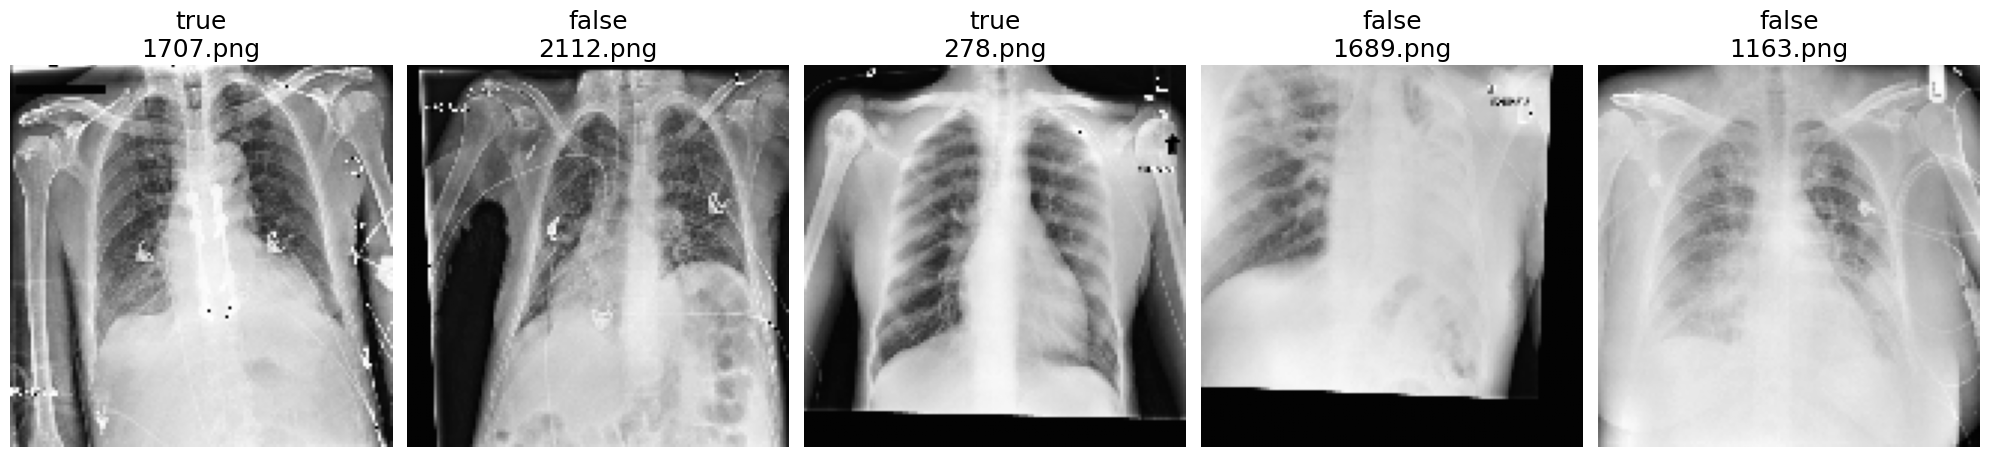

In [ ]:
# I use train files and labels
show_sample_images(train_files,train_labels)

In [ ]:
import multiprocessing as mp

def load_and_convert_image(file):
    image = load_img(file, target_size=(128, 128))
    return img_to_array(image)

def convert_images_to_array_parallel(image_files):
    pool = mp.Pool(mp.cpu_count())  # Use all available CPU cores
    images = pool.map(load_and_convert_image, image_files)
    pool.close()
    pool.join()
    return np.array(images)

# Faster image loading
train_array = convert_images_to_array_parallel(train_files)
val_array = convert_images_to_array_parallel(val_files)
test_array = convert_images_to_array_parallel(test_files)


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255 , featurewise_center=True ,
#     rotation_range=10,  # Randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # Randomly horizontal shift images
#     height_shift_range=0.1,  # Randomly vertical shift images
#     horizontal_flip=True,  # Randomly flip images horizontally
#     vertical_flip=True  # Usually not used for natural images
)

val_datagen = ImageDataGenerator(rescale=1./255   , featurewise_center=True)
test_datagen = ImageDataGenerator(rescale=1./255  , featurewise_center=True)


In [ ]:
# just call fit on training data
train_datagen.fit(train_array)
val_datagen.mean = train_datagen.mean
test_datagen.mean = train_datagen.mean

In [ ]:
# Setup the generators
train_generator = train_datagen.flow(
    x=train_array,
    y=train_labels_enc,  # accourding to Convert labels to one-hot encodings part
    batch_size=64,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=val_array,  # Assuming val_array is a numpy array of your validation images
    y=val_labels_enc,
    batch_size=64,
    shuffle=False
)

test_generator = test_datagen.flow(
    x=test_array,  # Assuming test_array is a numpy array of your test images
    y=test_labels_enc,
    batch_size=64,
    shuffle=False
)

In [ ]:
cnn = tf.keras.models.Sequential()

#---------------------------------------------------------------------------------------------------------#

#layer  >>> add conv layer + batch normalization + add pooling + dropout
# Starting with small kernels
cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same' ,input_shape=(128, 128, 3)))
# Followed by larger kernels
cnn.add(Conv2D(filters=16, kernel_size=(7, 7), activation='relu', padding='same'))
# Including a dilated convolution
cnn.add(Conv2D(filters=16, kernel_size=(3, 3), dilation_rate=2, activation='relu', padding='same'))
cnn.add( BatchNormalization())
cnn.add( MaxPooling2D(pool_size=2, strides=2))
cnn.add( Dropout(0.5) )

# Starting with small kernels
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# Followed by larger kernels
cnn.add(Conv2D(filters=32, kernel_size=(7, 7), activation='relu', padding='same'))
# Including a dilated convolution
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), dilation_rate=2, activation='relu', padding='same'))
cnn.add( BatchNormalization())
cnn.add( MaxPooling2D(pool_size=2, strides=2))
cnn.add( Dropout(0.5) )

# Starting with small kernels
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# Followed by larger kernels
cnn.add(Conv2D(filters=32, kernel_size=(7, 7), activation='relu', padding='same'))
# Including a dilated convolution
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), dilation_rate=2, activation='relu', padding='same'))
cnn.add( BatchNormalization())
cnn.add( MaxPooling2D(pool_size=2, strides=2))
cnn.add( Dropout(0.5) )

# Starting with small kernels
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# Followed by larger kernels
cnn.add(Conv2D(filters=64, kernel_size=(7, 7), activation='relu', padding='same'))
# Including a dilated convolution
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=2, activation='relu', padding='same'))
cnn.add( BatchNormalization())
cnn.add( MaxPooling2D(pool_size=2, strides=2))
cnn.add( Dropout(0.5) )

# Starting with small kernels
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# Followed by larger kernels
cnn.add(Conv2D(filters=64, kernel_size=(7, 7), activation='relu', padding='same'))
# Including a dilated convolution
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=2, activation='relu', padding='same'))
cnn.add( BatchNormalization())
cnn.add( MaxPooling2D(pool_size=2, strides=2))
cnn.add( Dropout(0.5) )

# Starting with small kernels
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# Followed by larger kernels
cnn.add(Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding='same'))
# Including a dilated convolution
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=2, activation='relu', padding='same'))
cnn.add( BatchNormalization())
cnn.add( MaxPooling2D(pool_size=2, strides=2))
cnn.add( Dropout(0.5) )


# Starting with small kernels
cnn.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# Followed by larger kernels
cnn.add(Conv2D(filters=256, kernel_size=(7, 7), activation='relu', padding='same'))
# Including a dilated convolution
cnn.add(Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=2, activation='relu', padding='same'))
cnn.add( BatchNormalization())
cnn.add( MaxPooling2D(pool_size=1, strides=1))
cnn.add( Dropout(0.5) )



#---------------------------------------------------------------------------------------------------------#

#flattening befor full conection
cnn.add( Flatten() )

#---------------------------------------------------------------------------------------------------------#

# # fully connected layer 1
cnn.add(Dense(1024, activation='relu'))
cnn.add( BatchNormalization())

# # fully connected layer 2
cnn.add(Dense(512, activation='relu'))
cnn.add( BatchNormalization())

# # fully connected layer 3
cnn.add(Dense(256, activation='relu'))
cnn.add( BatchNormalization())

#---------------------------------------------------------------------------------------------------------#

# out put layer at the ent of network
cnn.add( tf.keras.layers.Dense(units=2 , activation='softmax') )

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 16)        │          12,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │         200,7

 Total params: 7,515,874 (28.67 MB)

 Trainable params: 7,511,106 (28.65 MB)

 Non-trainable params: 4,768 (18.62 KB)

In [ ]:
# Define the EarlyStopping callback to monitor the validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=12,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_model.h5',  # Path to save the model file
    monitor='val_loss',  # Change to val_loss to monitor the validation loss
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the monitored metric has minimized
)


# Compile the model
cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model
history = cnn.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping , model_checkpoint]  # Add the EarlyStopping callback
)



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5076 - loss: 0.8644
Epoch 1: val_loss improved from inf to 0.70158, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 688ms/step - accuracy: 0.5077 - loss: 0.8633 - val_accuracy: 0.5011 - val_loss: 0.7016
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5538 - loss: 0.6826
Epoch 2: val_loss did not improve from 0.70158
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.5540 - loss: 0.6825 - val_accuracy: 0.4989 - val_loss: 0.7639
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6016 - loss: 0.6629
Epoch 3: val_loss did not improve from 0.70158
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.6017 - loss: 0.6628 - val_accuracy: 0.4989 - val_loss: 0.7048
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6275 - loss: 0.6419
Epoch 4: val_loss improved from 0.70158 to 0.66609, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.6277 - loss: 0.6418 - val_accuracy: 0.6022 - val_loss: 0.6661
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6500 - loss: 0.6209
Epoch 5: val_loss did not improve from 0.66609
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6500 - loss: 0.6209 - val_accuracy: 0.6438 - val_loss: 0.6883
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6745 - loss: 0.6044
Epoch 6: val_loss improved from 0.66609 to 0.61769, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.6746 - loss: 0.6044 - val_accuracy: 0.6697 - val_loss: 0.6177
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6743 - loss: 0.6084
Epoch 7: val_loss improved from 0.61769 to 0.61284, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.6744 - loss: 0.6083 - val_accuracy: 0.6697 - val_loss: 0.6128
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6869 - loss: 0.5908
Epoch 8: val_loss did not improve from 0.61284
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6869 - loss: 0.5909 - val_accuracy: 0.6337 - val_loss: 0.6585
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6923 - loss: 0.5880
Epoch 9: val_loss improved from 0.61284 to 0.58608, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.6924 - loss: 0.5880 - val_accuracy: 0.6921 - val_loss: 0.5861
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6946 - loss: 0.5780
Epoch 10: val_loss did not improve from 0.58608
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.6946 - loss: 0.5780 - val_accuracy: 0.6494 - val_loss: 0.6361
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7105 - loss: 0.5585
Epoch 11: val_loss did not improve from 0.58608
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.7105 - loss: 0.5585 - val_accuracy: 0.6528 - val_loss: 0.6464
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7141 - loss: 0.5615
Epoch 12: val_loss did not improve from 0.58608
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.7140 - loss: 0.5614 - val_accuracy: 0.6876 - val_loss: 0.5891
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7126 - loss: 0.5594
Epoch 13: val_loss did not improv

56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.7342 - loss: 0.5173 - val_accuracy: 0.7292 - val_loss: 0.5492
Epoch 16/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7548 - loss: 0.5157
Epoch 16: val_loss improved from 0.54921 to 0.53600, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.7548 - loss: 0.5157 - val_accuracy: 0.7281 - val_loss: 0.5360
Epoch 17/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7520 - loss: 0.5109
Epoch 17: val_loss did not improve from 0.53600
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.7520 - loss: 0.5108 - val_accuracy: 0.7157 - val_loss: 0.5424
Epoch 18/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7527 - loss: 0.5013
Epoch 18: val_loss improved from 0.53600 to 0.50728, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.7529 - loss: 0.5011 - val_accuracy: 0.7539 - val_loss: 0.5073
Epoch 19/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7447 - loss: 0.4981
Epoch 19: val_loss did not improve from 0.50728
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.7449 - loss: 0.4981 - val_accuracy: 0.7438 - val_loss: 0.5097
Epoch 20/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7658 - loss: 0.4853
Epoch 20: val_loss did not improve from 0.50728
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.7659 - loss: 0.4853 - val_accuracy: 0.6090 - val_loss: 0.8079
Epoch 21/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7745 - loss: 0.4780
Epoch 21: val_loss did not improve from 0.50728
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.7745 - loss: 0.4779 - val_accuracy: 0.7258 - val_loss: 0.5270
Epoch 22/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7726 - loss: 0.4807
Epoch 22: val_loss did not improve

56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.7792 - loss: 0.4653 - val_accuracy: 0.7629 - val_loss: 0.4910
Epoch 26/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7707 - loss: 0.4688
Epoch 26: val_loss did not improve from 0.49105
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.7709 - loss: 0.4685 - val_accuracy: 0.7528 - val_loss: 0.5734
Epoch 27/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7922 - loss: 0.4487
Epoch 27: val_loss improved from 0.49105 to 0.48197, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.7921 - loss: 0.4488 - val_accuracy: 0.7775 - val_loss: 0.4820
Epoch 28/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8147 - loss: 0.4121
Epoch 28: val_loss did not improve from 0.48197
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8145 - loss: 0.4124 - val_accuracy: 0.7270 - val_loss: 0.5602
Epoch 29/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8076 - loss: 0.4235
Epoch 29: val_loss improved from 0.48197 to 0.46291, saving model to /content/drive/MyDrive/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.8076 - loss: 0.4237 - val_accuracy: 0.7775 - val_loss: 0.4629
Epoch 30/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8157 - loss: 0.4133
Epoch 30: val_loss did not improve from 0.46291
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.8156 - loss: 0.4135 - val_accuracy: 0.7685 - val_loss: 0.4812
Epoch 31/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8053 - loss: 0.4210
Epoch 31: val_loss did not improve from 0.46291
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8051 - loss: 0.4213 - val_accuracy: 0.6978 - val_loss: 0.6261
Epoch 32/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7990 - loss: 0.4316
Epoch 32: val_loss did not improve from 0.46291
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.7991 - loss: 0.4314 - val_accuracy: 0.7584 - val_loss: 0.5082
Epoch 33/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7986 - loss: 0.4254
Epoch 33: val_loss did not improve

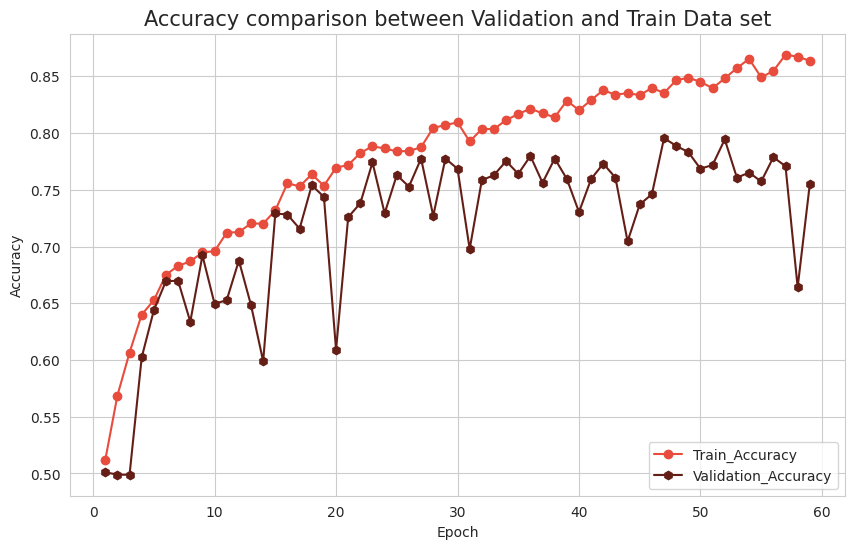

In [ ]:
plt.figure(figsize=(10,6))
sn.set_style("whitegrid")
plt.plot(range(1, len(cnn.history.history['accuracy'])+1), cnn.history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(range(1, len(cnn.history.history['val_accuracy'])+1), cnn.history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Accuracy', 'Validation_Accuracy'], loc='lower right')
plt.show()


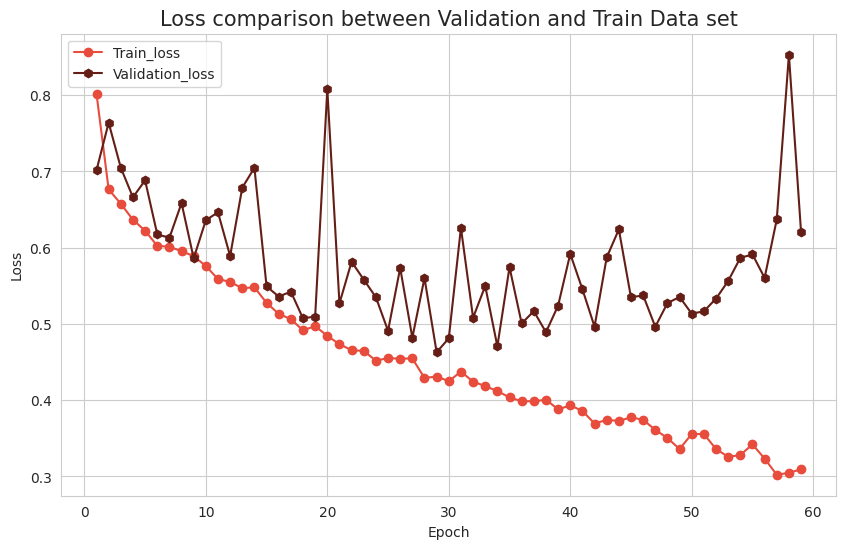

In [ ]:
plt.figure(figsize=(10,6))
sn.set_style("whitegrid")
plt.plot(range(1, len(cnn.history.history['accuracy'])+1), cnn.history.history['loss'], color="#E74C3C", marker='o')
plt.plot(range(1, len(cnn.history.history['val_accuracy'])+1), cnn.history.history['val_loss'], color='#641E16', marker='h')
plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Validation_loss'], loc='upper left')
plt.show()

In [ ]:

# Load the saved model
# If the best model is captured by the early stopping mechanism then best_model = cnn
# best_model = cnn
best_model = load_model('/content/drive/MyDrive/best_model.h5')



# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_generator)
val_loss, val_accuracy = best_model.evaluate(val_generator)
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8171 - loss: 0.4136
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.7847 - loss: 0.4463
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.8007 - loss: 0.4600
train loss: 0.40657472610473633
train accuracy: 0.8271501064300537
------------------------
val loss: 0.4629117548465729
val accuracy: 0.7775281071662903
------------------------
Test loss: 0.45880448818206787
Test accuracy: 0.7845601439476013


In [ ]:
# Assuming best_model is your trained Keras model

# Get the predicted labels from the model
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Convert one-hot encoded true labels back to class indices
y_true = np.argmax(test_labels_enc, axis=-1)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)

print("\nClassification Report:")
print(report)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
Confusion Matrix:
[[418 139]
 [101 456]]

Classification Report:
              precision    recall  f1-score   support

       false       0.81      0.75      0.78       557
        true       0.77      0.82      0.79       557

    accuracy                           0.78      1114
   macro avg       0.79      0.78      0.78      1114
weighted avg       0.79      0.78      0.78      1114



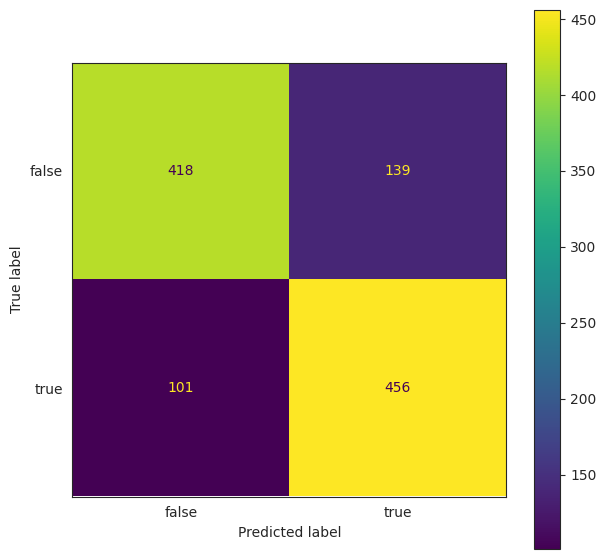

In [ ]:
#Confusion matrix

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation='horizontal')
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)